<a href="https://colab.research.google.com/github/a-donat/Benchmarks_PyCaret/blob/main/Predicting_Amsterdam_Weekend_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Set-Up

## I.A. Import Libraries and Download Data

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d thedevastator/airbnb-prices-in-european-cities
! unzip '/content/airbnb-prices-in-european-cities.zip' -d '/content/data'

In [ ]:
! pip install pycaret

In [3]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#import VisualizeDataAbbrev as viz

import numpy as np
import pandas as pd
from pycaret.regression import *
from sklearn.model_selection import train_test_split

## I.B. Load Data and Check Data Integrity

In [57]:
ds_df = pd.read_csv("/content/data/amsterdam_weekdays.csv")
# https://zenodo.org/record/4446043#.ZEV8d-zMI-R

In [58]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  1103 non-null   int64  
 1   realSum                     1103 non-null   float64
 2   room_type                   1103 non-null   object 
 3   room_shared                 1103 non-null   bool   
 4   room_private                1103 non-null   bool   
 5   person_capacity             1103 non-null   float64
 6   host_is_superhost           1103 non-null   bool   
 7   multi                       1103 non-null   int64  
 8   biz                         1103 non-null   int64  
 9   cleanliness_rating          1103 non-null   float64
 10  guest_satisfaction_overall  1103 non-null   float64
 11  bedrooms                    1103 non-null   int64  
 12  dist                        1103 non-null   float64
 13  metro_dist                  1103 

In [59]:
ds_df = ds_df.drop(columns=["Unnamed: 0"]).copy()

In [60]:
ds_df.nunique()

realSum                        534
room_type                        3
room_shared                      2
room_private                     2
person_capacity                  5
host_is_superhost                2
multi                            2
biz                              2
cleanliness_rating               7
guest_satisfaction_overall      32
bedrooms                         6
dist                          1103
metro_dist                    1103
attr_index                    1103
attr_index_norm               1103
rest_index                    1103
rest_index_norm               1103
lng                           1022
lat                            950
dtype: int64

In [61]:
ds_df.corr().round(2)

<ipython-input-61-5fd8ea8afd93>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ds_df.corr().round(2)


,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
realSum,1.00,-0.05,-0.43,0.53,-0.06,-0.10,-0.03,0.02,0.14,0.49,-0.26,-0.14,0.24,0.24,0.21,0.21,-0.03,0.09
room_shared,-0.05,1.00,-0.07,-0.01,0.01,0.03,-0.03,-0.03,-0.02,-0.03,0.04,0.02,-0.01,-0.01,-0.01,-0.01,-0.01,0.00
room_private,-0.43,-0.07,1.00,-0.38,0.17,0.24,0.08,0.03,-0.13,-0.38,0.10,0.05,0.00,0.00,0.04,0.04,0.08,-0.05
person_capacity,0.53,-0.01,-0.38,1.00,-0.09,-0.14,0.08,-0.07,0.04,0.66,-0.05,-0.00,0.04,0.04,0.01,0.01,-0.01,0.07
host_is_superhost,-0.06,0.01,0.17,-0.09,1.00,0.10,-0.14,0.31,0.30,-0.06,0.02,0.04,-0.02,-0.02,-0.02,-0.02,-0.06,0.02
multi,-0.10,0.03,0.24,-0.14,0.10,1.00,-0.24,0.01,-0.05,-0.11,0.01,-0.03,0.00,0.00,0.05,0.05,-0.03,-0.02
biz,-0.03,-0.03,0.08,0.08,-0.14,-0.24,1.00,-0.06,-0.12,-0.04,-0.04,-0.04,0.10,0.10,0.10,0.10,0.07,0.05
cleanliness_rating,0.02,-0.03,0.03,-0.07,0.31,0.01,-0.06,1.00,0.65,-0.02,-0.02,0.02,-0.01,-0.01,0.01,0.01,-0.03,0.03
guest_satisfaction_overall,0.14,-0.02,-0.13,0.04,0.30,-0.05,-0.12,0.65,1.00,0.10,-0.06,0.05,0.01,0.01,-0.00,-0.00,-0.05,0.09
bedrooms,0.49,-0.03,-0.38,0.66,-0.06,-0.11,-0.04,-0.02,0.10,1.00,0.02,0.02,-0.02,-0.02,-0.07,-0.07,-0.01,-0.01



# II. Preprocessing

In [62]:
train_df, test_df = train_test_split(
    ds_df, test_size=0.20, random_state=1)

# III. Create Models

In [63]:
reg_models = setup(data=train_df, target="realSum", session_id=123,
                   ignore_features=["attr_index", "rest_index"])


,Description,Value
0,Session id,123
1,Target,realSum
2,Target type,Regression
3,Original data shape,"(882, 19)"
4,Transformed data shape,"(882, 19)"
5,Transformed train set shape,"(617, 19)"
6,Transformed test set shape,"(265, 19)"
7,Ignore features,2
8,Numeric features,12
9,Categorical features,1


In [64]:
best_model = compare_models(fold=5)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,157.2366,58850.1803,241.0914,0.5521,0.3899,0.3050,0.9500
ridge,Ridge Regression,157.1332,58930.0510,241.2646,0.5514,0.3804,0.3036,0.2500
lasso,Lasso Regression,156.9295,59086.0866,241.5685,0.5502,0.3886,0.3031,0.2740
llar,Lasso Least Angle Regression,156.9314,59086.9773,241.5704,0.5502,0.3886,0.3031,0.1260
br,Bayesian Ridge,156.8449,59108.1345,241.6028,0.5501,0.3899,0.3039,0.1260
rf,Random Forest Regressor,151.4572,61143.8573,245.3680,0.5354,0.3361,0.2780,0.8820
huber,Huber Regressor,148.7413,62048.1177,247.1483,0.5299,0.3488,0.2681,0.1520
en,Elastic Net,155.8589,62552.0421,248.0833,0.5266,0.3544,0.3061,0.1160
lightgbm,Light Gradient Boosting Machine,158.5847,61770.4983,247.6659,0.5217,0.3496,0.2894,0.6820
gbr,Gradient Boosting Regressor,149.3749,61937.4291,247.2113,0.5215,0.3356,0.2749,0.3600


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

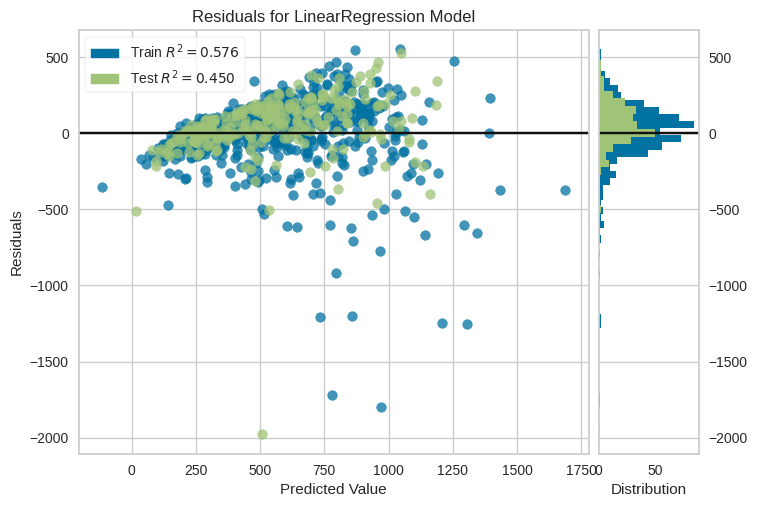

In [65]:
plot_model(best_model)

In [66]:
reg_models2 = setup(data=train_df, target="realSum", session_id=124,
                    ignore_features=["attr_index", "rest_index", "lat", "lng"])


,Description,Value
0,Session id,124
1,Target,realSum
2,Target type,Regression
3,Original data shape,"(882, 19)"
4,Transformed data shape,"(882, 17)"
5,Transformed train set shape,"(617, 17)"
6,Transformed test set shape,"(265, 17)"
7,Ignore features,4
8,Numeric features,10
9,Categorical features,1


In [67]:
best_model2 = compare_models(fold=5)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,125.5264,42252.3197,201.8334,0.6202,0.2933,0.2384,0.5680
gbr,Gradient Boosting Regressor,126.6578,43208.8878,203.7172,0.6109,0.2970,0.2415,0.3340
lightgbm,Light Gradient Boosting Machine,130.0883,43017.3562,205.1378,0.6030,0.3022,0.2476,0.1660
et,Extra Trees Regressor,128.4215,44710.6588,207.4102,0.5968,0.3030,0.2411,0.9100
lasso,Lasso Regression,138.2860,45135.9638,209.6775,0.5872,0.3514,0.2742,0.2160
llar,Lasso Least Angle Regression,138.2861,45136.2148,209.6780,0.5872,0.3515,0.2742,0.1260
br,Bayesian Ridge,138.3717,45222.9095,209.8519,0.5865,0.3545,0.2754,0.1240
ridge,Ridge Regression,138.7505,45169.9864,209.8380,0.5863,0.3575,0.2757,0.2120
lr,Linear Regression,138.9302,45183.5112,209.8807,0.5861,0.3576,0.2761,0.1620
lar,Least Angle Regression,138.9302,45183.5112,209.8807,0.5861,0.3576,0.2761,0.2040


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

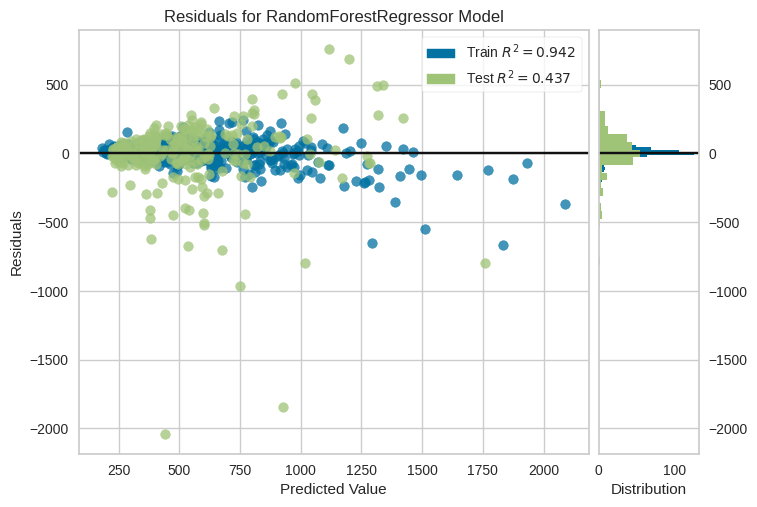

In [68]:
plot_model(best_model2)

In [69]:
rf = create_model("rf")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,128.7490,35067.8282,187.2641,0.6830,0.2713,0.2358
1,185.2651,114240.6221,337.9950,0.4287,0.3724,0.2796
2,120.3701,40807.1114,202.0077,0.6741,0.2689,0.2261
3,126.6553,33196.1629,182.1981,0.6581,0.2962,0.2576
4,120.2944,28348.6884,168.3707,0.6270,0.2909,0.2499
5,118.9099,34044.6038,184.5118,0.5686,0.2636,0.2015
6,127.3771,54216.3516,232.8440,0.5213,0.3166,0.2460
7,151.9028,60885.7057,246.7503,0.5019,0.3367,0.2754
8,85.1443,17480.1584,132.2126,0.6505,0.2568,0.2135


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [70]:
preds_rf = predict_model(rf, train_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,77.7984,25938.2659,161.0536,0.7746,0.2108,0.1417


In [72]:
preds_rf["residual"] = preds_rf["realSum"] - preds_rf["prediction_label"]
preds_rf["scaled_residual"] = preds_rf["residual"] / preds_rf["realSum"]

In [73]:
import matplotlib.pyplot as plt

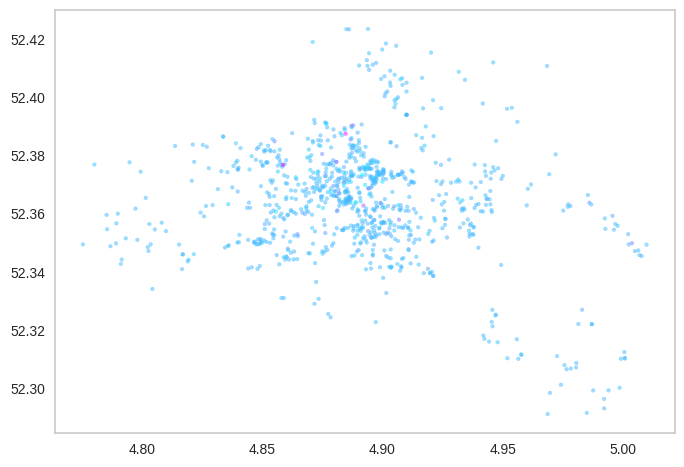

In [78]:
plt.grid(False)
plt.scatter(
    data=preds_rf, x="lng", y="lat", c="residual",
    alpha=.5, cmap="cool", s=7)

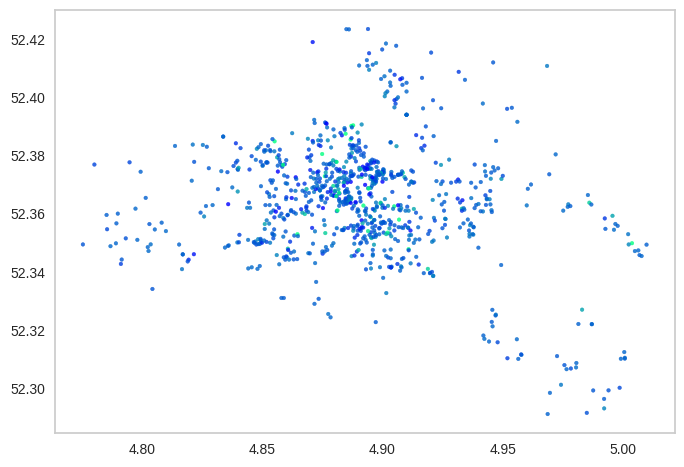

In [87]:
plt.grid(False)
plt.scatter(
    data=preds_rf, x="lng", y="lat",
    c=preds_rf["residual"].clip(
        preds_rf["residual"].quantile(.02),
        preds_rf["residual"].quantile(.98)),
    alpha=.8, cmap="winter", s=7)

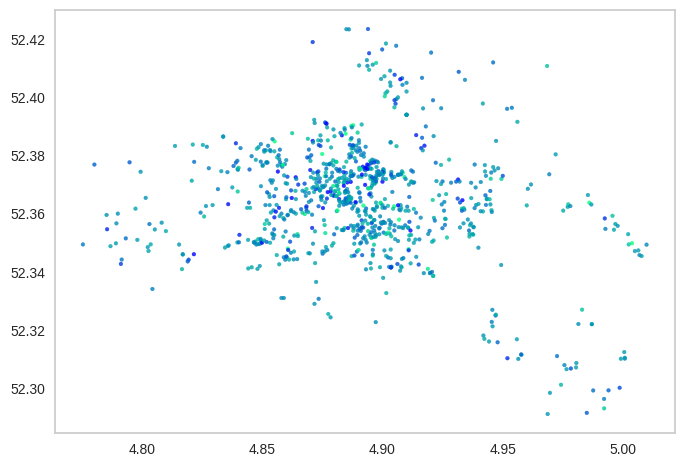

In [86]:
plt.grid(False)
plt.scatter(
    data=preds_rf, x="lng", y="lat",
    c=preds_rf["scaled_residual"].clip(
        preds_rf["scaled_residual"].quantile(.02),
        preds_rf["scaled_residual"].quantile(.98)),
    alpha=.8, cmap="winter", s=7)

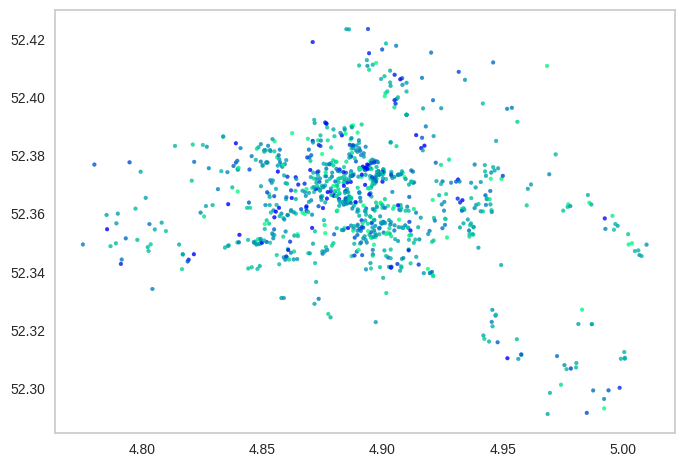

In [88]:
plt.grid(False)
plt.scatter(
    data=preds_rf, x="lng", y="lat",
    c=preds_rf["scaled_residual"].clip(
        preds_rf["scaled_residual"].quantile(.05),
        preds_rf["scaled_residual"].quantile(.95)),
    alpha=.8, cmap="winter", s=7)

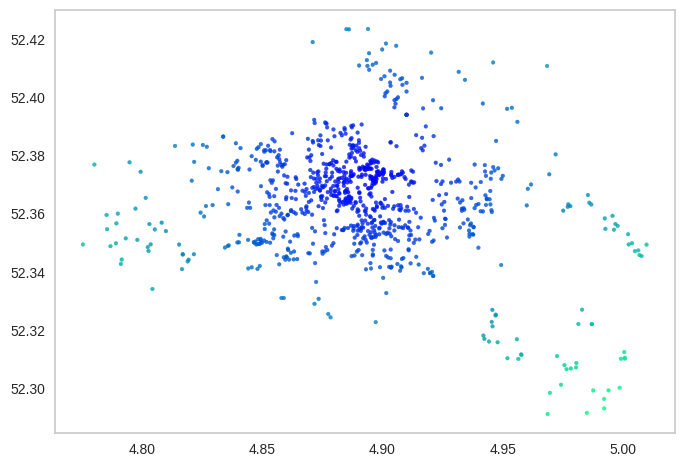

In [89]:
plt.grid(False)
plt.scatter(
    data=preds_rf, x="lng", y="lat",
    c=preds_rf["dist"],
    alpha=.8, cmap="winter", s=7)